# Import packages
You must have the file sioread.py in your directory for this to work

In [1]:
%matplotlib inline
import glob
import numpy as np
from sioread import sioread
import os
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
# for parallel processing
from joblib import Parallel, delayed
import multiprocessing



# Define paths and variables
It's set up to read a file/files from the VLA2 of the SCE17 experiment. It will read the whole file (60 seconds). The selected frequencies are between 50 Hz and 200 Hz.

The option to read the HLA data is in progress (reader is not configured for it as of Mar. 7, 2018).

In [2]:
PLOT = True
jd = np.array([82]) # Julian Day, 2017

fs = 25000 # 1s/1Hz resolution
nfft = fs
f = np.fft.fftfreq(nfft,d=1/fs)
bandwidth = np.arange(50,203,3) # select frequencies, Hz
window = np.hanning(nfft)

L = 60 # length of data (in seconds)

# # # for the VLAs # # #
M=16 # number of hydrophones
#path = '../../project/SCE17/acoustic/SCE17_VLA2_sio/'
path = ''
files1 = glob.glob(path + 'RAVA02.170' +  str(jd[0]) + '*.sio')

# # # for the HLA # # #
#M=64 # number of hydrophones
#path = '../../project/SCE17/FFI/Disk2/'
#files1 = glob.glob(path + '22032017_*')

print('files: ' + files1[0])


files: RAVA02.17082190900.000.sio


# Define useful functions (for parallelization)

In [3]:
def load_VLA(fi,L,fs,nfft,f_select,M):
    x = sioread(fi,1,0,0)
    N = x.shape[0]
    K = int((fs*L)/nfft)
    D = np.empty([K,M,len(f_select)],dtype=complex)
    for l in np.arange(0,K):
        y = np.fft.fft(x[np.arange(0,nfft) + (l-1)*nfft,:],nfft,0,norm='ortho')
        D[l,:,:] = y[f_select,:].transpose() # samples X sensors X freq
    t = time.time()
    return D
    np.save('processed_VLA2_'+ fi[7:18],D)  

# Read in the data
Most of the reading is done inside sioread. If you have problems with reading the data, first check if you want little- or big-endian (current=big-endian). Then check the data formatting.

Connected to 8 cores.
2.08 seconds.


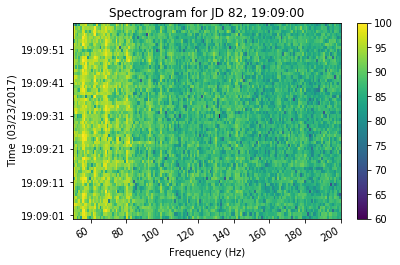

In [4]:
f_select = np.where(np.logical_and(np.array(f>=bandwidth[0]), np.array(f<=bandwidth[-1])))[0]
if path.find("VLA"):
    t0=time.time()
    num_cores = multiprocessing.cpu_count()
    print('Connected to ' + str(num_cores) + ' cores.')
    D = Parallel(n_jobs=num_cores)(delayed(load_VLA)(i,L,fs,nfft,f_select,M) for i in files1)
elif path.find("FFI"): # # # #This part still needs some work
    fid = open( path + files1(ii).name ,'rb')
   # hdr = dataFileHdr( fid )
   # x   = fread(fid,[hdr.nChannels hdr.nSamples],hdr.precision);
   # x = x.transpose()
   # x = x(:,28:37); # if you want to use fewer than full HLA

if np.sum(np.sum(np.isnan(D)))/len(D[:]) != 0:
    print('There are nans in your data. Beware. (usually caused by read error)')

t1 = '0' + files1[0][10:12] + '/2017 ' + files1[0][12:14] +':' + files1[0][14:16] + ':00'
t2 = '0' + files1[-1][10:12] + '/2017 ' + files1[-1][12:14] +':' + str(int(files1[-1][14:16])+1) + ':00'
d_ends = [dt.datetime.strptime(x, '%j/%Y %H:%M:%S') for x in [t1,t2]]
dnum = np.arange(d_ends[0],d_ends[-1], dt.timedelta(seconds=1)).astype(dt.datetime)  # compute the datetime vector    

if PLOT:
    y_lims = mdates.date2num(dnum)

    fig, ax = plt.subplots()
    I = 0
    h = ax.imshow(10*np.log10(np.abs(D[I][:,0,:])),aspect='auto',
                  extent=[f[f_select[0]],f[f_select[-1]],y_lims[0],y_lims[-1]],vmin=60,vmax=100)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Time (' + dnum[0].strftime('%m/%d/%Y') + ')')
    plt.title('Spectrogram for JD ' + files1[I][10:12] + ', ' + files1[I][12:14] + ':' + files1[I][14:16] + ':00')

    # convert y-axis to time labels
    ax.yaxis_date()
    date_format = mdates.DateFormatter('%H:%M:%S')
    ax.yaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    c = fig.colorbar(h,ax=ax)
    
t = time.time()
print("{0:.2f}".format(t-t0) + ' seconds.')
    